In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import LSTM,Dropout,Dense,GRU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving prices-split-adjusted.csv to prices-split-adjusted.csv
User uploaded file "prices-split-adjusted.csv" with length 52701226 bytes


In [4]:
uploaded
import pandas as pd
import io
df=pd.read_csv(io.StringIO(uploaded['prices-split-adjusted.csv'].decode('utf-8')))

In [19]:

df=df.set_index('date')
print(df.isnull().sum())
print(df.head())
print(df.shape)

print(len(df['symbol'].unique()))
print(df['symbol'].unique())

symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64
           symbol        open       close         low        high     volume
date                                                                        
2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002  1408600.0
(851264, 6)
501
['WLTW' 'A' 'AAL' 'AAP' 'AAPL' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADS' 'ADSK' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIZ' 'AJG' 'AKAM'
 'ALB' 'ALK' 'ALL' 'ALXN' 'AMAT' 'AME' 'AMG' 'AMGN' 'AMP' 'AMT' 'AMZN'
 'AN' 'ANTM' 'AON' 'APA' 'APC' 'APD' 'APH' 'ARNC' 'ATVI' 'AVB' 'AVGO'
 'AVY' 'AWK' 'AXP' 'AYI' 'AZO' 'BA' 'BAC' 'BAX' 'BBBY' 'BBT' 'BBY' 'BC

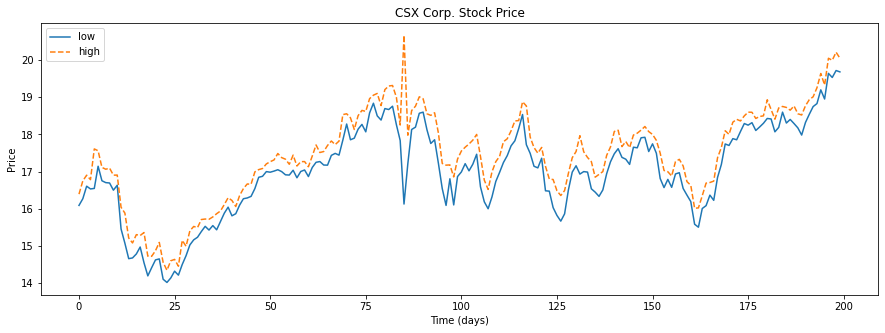

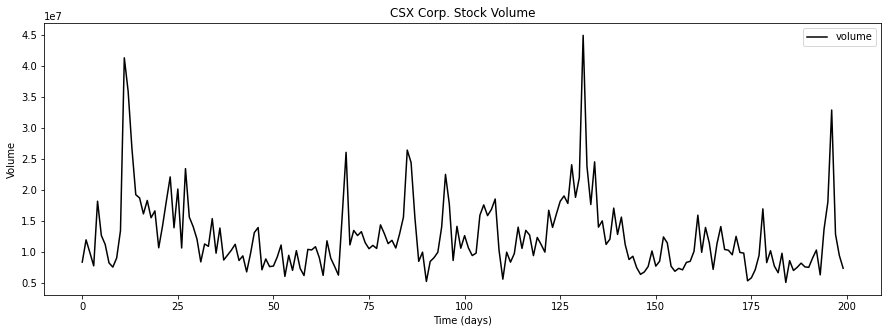

In [20]:
plt.figure(figsize=(15, 5));

plt.plot(df[df.symbol == 'CSX'].low.values[:200],linestyle = '-', label='low')
plt.plot(df[df.symbol == 'CSX'].high.values[:200],linestyle = '--', label='high')
plt.title('CSX Corp. Stock Price')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(df[df.symbol == 'CSX'].volume.values[:200], color='black', label='volume')
plt.title('CSX Corp. Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.show()

In [21]:
google_df = df[df.symbol =='GOOG']
google_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1762 non-null   object 
 1   open    1762 non-null   float64
 2   close   1762 non-null   float64
 3   low     1762 non-null   float64
 4   high    1762 non-null   float64
 5   volume  1762 non-null   float64
dtypes: float64(5), object(1)
memory usage: 96.4+ KB


In [22]:
google = google_df.drop(columns=['symbol'])

print(google.shape)
google.head()

(1762, 5)


,open,close,low,high,volume
date,,,,,
2010-01-04,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,294.895159,299.886470,293.455551,300.499172,9483900.0


In [23]:
def normalize_data(df):
    scaler = MinMaxScaler()
    columns = df.columns
    for col in columns:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
    return df

In [29]:
goog = normalize_data(google)

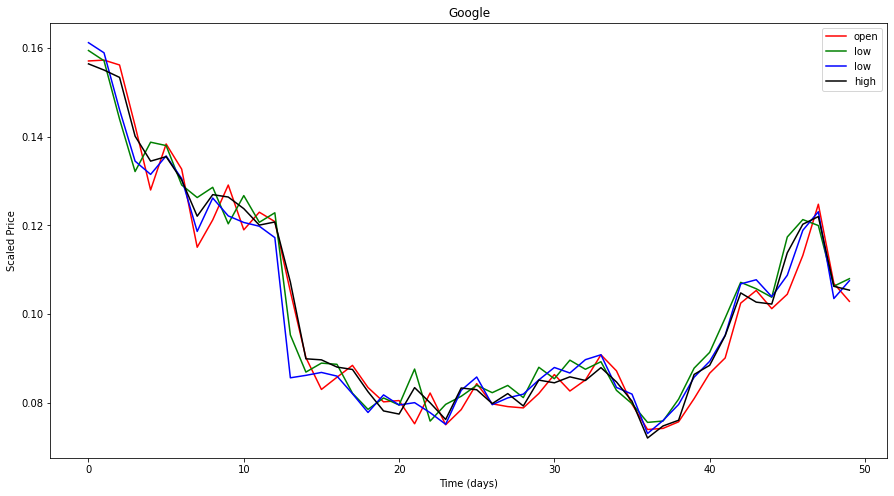

In [30]:
plt.figure(figsize=(15, 8));
plt.plot(goog.open.values[:50], color='red', label='open')
plt.plot(goog.close.values[:50], color='green', label='low')
plt.plot(goog.low.values[:50], color='blue', label='low')
plt.plot(goog.high.values[:50], color='black', label='high')
plt.title('Google')
plt.xlabel('Time (days)')
plt.ylabel('Scaled Price')
plt.legend(loc='best')
plt.show()


In [33]:
goog = goog.drop(columns = ['volume'])
train_size = int(len(goog) * 0.8)
test_size = int(len(goog) - train_size)
train, test = goog[0:train_size], goog[train_size:len(goog)]

In [34]:
print(train.shape,test.shape)

(1409, 4) (353, 4)


In [35]:
train_X ,train_y = train[['open','low','high']],train['close']
test_X, test_y = test[['open','low','high']],test['close']
train_X ,train_y,test_X, test_y = np.array(train_X),np.array(train_y),np.array(test_X),np.array(test_y)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1409, 1, 3) (1409,) (353, 1, 3) (353,)


In [36]:
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
29/29 - 1s - loss: 0.0037 - val_loss: 0.0020
Epoch 2/50
29/29 - 0s - loss: 0.0050 - val_loss: 2.1085e-04
Epoch 3/50
29/29 - 0s - loss: 0.0020 - val_loss: 3.6552e-04
Epoch 4/50
29/29 - 0s - loss: 6.7741e-04 - val_loss: 1.3654e-04
Epoch 5/50
29/29 - 0s - loss: 2.4861e-04 - val_loss: 1.4215e-04
Epoch 6/50
29/29 - 0s - loss: 1.6896e-04 - val_loss: 1.5610e-04
Epoch 7/50
29/29 - 0s - loss: 1.4860e-04 - val_loss: 1.6580e-04
Epoch 8/50
29/29 - 0s - loss: 1.4179e-04 - val_loss: 1.6939e-04
Epoch 9/50
29/29 - 0s - loss: 1.3872e-04 - val_loss: 1.7045e-04
Epoch 10/50
29/29 - 0s - loss: 1.3688e-04 - val_loss: 1.7039e-04
Epoch 11/50
29/29 - 0s - loss: 1.3549e-04 - val_loss: 1.6992e-04
Epoch 12/50
29/29 - 0s - loss: 1.3428e-04 - val_loss: 1.6918e-04
Epoch 13/50
29/29 - 0s - loss: 1.3319e-04 - val_loss: 1.6819e-04
Epoch 14/50
29/29 - 0s - loss: 1.3216e-04 - val_loss: 1.6726e-04
Epoch 15/50
29/29 - 0s - loss: 1.3116e-04 - val_loss: 1.6624e-04
Epoch 16/50
29/29 - 0s - loss: 1.3021e-04 - val_lo

In [37]:
results_train = model.evaluate(train_X, train_y)
results_test = model.evaluate(test_X, test_y)

print(results_train)
print(results_test)

12/12 [==============================] - 0s 2ms/step - loss: 1.4381e-04
6.817004759795964e-05
0.00014380966604221612


In [38]:
pred_train = model.predict(train_X).reshape(-1)
pred_test = model.predict(test_X).reshape(-1)

LSTM1_MSE_train = np.mean((pred_train-train_y)**2)
LSTM1_MSE_test = np.mean((pred_test-test_y)**2)


print(LSTM1_MSE_train)
print(LSTM1_MSE_test)

6.817004841243947e-05
0.00014380967725633617


In [39]:
model_predict= {}
model_predict['Single Layer LSTM'] = {'Test MSE': LSTM1_MSE_test, 'Train MSE':LSTM1_MSE_train}

In [40]:
model2 = Sequential()
model2.add(GRU(200, input_shape=(1,3),return_sequences=True))
model.add(Dropout(0.2))
model2.add(GRU(200, input_shape=(1,3)))
model.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mse', optimizer='rmsprop')

# fit network
history2 = model2.fit(train_X, train_y, epochs=70, batch_size=50, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/70
29/29 - 1s - loss: 0.0028 - val_loss: 2.9317e-04
Epoch 2/70
29/29 - 0s - loss: 0.0021 - val_loss: 1.3783e-04
Epoch 3/70
29/29 - 0s - loss: 0.0017 - val_loss: 1.0150e-04
Epoch 4/70
29/29 - 0s - loss: 0.0014 - val_loss: 1.0250e-04
Epoch 5/70
29/29 - 0s - loss: 0.0014 - val_loss: 9.0259e-05
Epoch 6/70
29/29 - 0s - loss: 0.0013 - val_loss: 1.8551e-04
Epoch 7/70
29/29 - 0s - loss: 0.0014 - val_loss: 9.4517e-05
Epoch 8/70
29/29 - 0s - loss: 0.0012 - val_loss: 2.7334e-04
Epoch 9/70
29/29 - 0s - loss: 0.0013 - val_loss: 1.0246e-04
Epoch 10/70
29/29 - 0s - loss: 0.0012 - val_loss: 2.4623e-04
Epoch 11/70
29/29 - 0s - loss: 0.0012 - val_loss: 1.0027e-04
Epoch 12/70
29/29 - 0s - loss: 0.0011 - val_loss: 3.0434e-04
Epoch 13/70
29/29 - 0s - loss: 0.0012 - val_loss: 1.0371e-04
Epoch 14/70
29/29 - 0s - loss: 0.0010 - val_loss: 3.7950e-04
Epoch 15/70
29/29 - 0s - loss: 0.0011 - val_loss: 1.0816e-04
Epoch 16/70
29/29 - 0s - loss: 9.8639e-04 - val_loss: 3.8119e-04
Epoch 17/70
29/29 - 0s - loss

In [42]:
results_train2 = model2.evaluate(train_X, train_y)
results_test2 = model2.evaluate(test_X, test_y)
print(results_train2)
print(results_test2)


pred_train2 = model2.predict(train_X).reshape(-1)
pred_test2 = model2.predict(test_X).reshape(-1)


GRU2_MSE_train = np.mean((pred_train2-train_y)**2)
GRU2_MSE_test = np.mean((pred_test2-test_y)**2)


print(GRU2_MSE_train)
print(GRU2_MSE_test)


model_predict['Multi-Layer GRU'] = {'Test MSE': GRU2_MSE_test, 'Train MSE':GRU2_MSE_train}


12/12 [==============================] - 0s 3ms/step - loss: 1.1646e-04
0.00023282325128093362
0.00011646498751360923
0.00023282322808943967
0.00011646498069594866
